In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import requests, PIL.Image, PIL.ImageDraw
import numpy as np
import matplotlib.pylab as pl
import glob
from matplotlib import pyplot as plt
from IPython.display import Image, HTML, clear_output
import io

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksprague1/CA-AE/blob/master/CA-AE.ipynb)

In [2]:
BATCH_SIZE = 2
x = torch.randn(2, 3)
print(x)
CHANNEL_N=4
seeds = np.zeros([BATCH_SIZE,CHANNEL_N],dtype=np.float32)
seeds[:,3:]=1.0
#print(seeds)
inits=torch.tensor(seeds)

def toimage(x,inits,size):
    """Test toimage function to make sure the code actually worked in the CA"""
    #now we turn the vector back into an image:
    
    combined = torch.cat([inits,x], dim=-1)
    #torch.cat(tensors, dim=0, *, out=None) → Tensor
    #Concatenates the given sequence of seq tensors in the given dimension. 
    #All tensors must either have the same shape (except in the concatenating dimension) or be empty.
    
    y = torch.unsqueeze(combined, 1)
    #torch.unsqueeze(input, dim) → Tensor
    #Returns a new tensor with a dimension of size one inserted at the specified position.
    y = torch.unsqueeze(y, 1)
    
    result = F.pad(input=y, pad=(0,0,size//2,size//2-1,size//2,size//2-1,0,0), mode='constant', value=0)
    #torch.nn.functional.pad(input, pad, mode='constant', value=0)
    #Note: pad should be a tuple of with size double the dimensions of your tensor
    #Note2: pads are in reverse order of dimension so pad=(1,1) will pad the last dimension
    return result


out = toimage(x,inits,6)

print(out)
print(out.shape)

tensor([[ 0.4080,  0.2848, -0.6589],
        [ 0.4648, -2.0475, -0.5552]])
torch.Size([2, 6, 6, 7])


# Note on Legality
The code here is highly illegal and should not be used for anything other than tutorial purposes.<br>
A large body of code here is from the google colab of the [The original paper](https://distill.pub/2020/growing-ca/). I looked at this and wanted to make a change where one model could grow multiple images (henc the auto encoder bit). I made these changes to the original notebook provided by google, then found a [Pytorch Implementation](https://github.com/chenmingxiang110/Growing-Neural-Cellular-Automata) of the code for this. I then made changes to the pytorch implementation to match what I had done earlier to the tensorflow version.<br>
<br>
So this is a dish cooked by [Alexander Mordvintsev](https://znah.net/), garnished by [chenmingxiang110](https://github.com/chenmingxiang110), and taken to the table by me.

In [3]:
model_path = "models/Test.pth"
device = torch.device("cuda:0")

#set up constants
CHANNEL_N = 20
DNA_N=6
# Number of CA state channels
TARGET_PADDING = 5   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 4
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

seeds = np.zeros([BATCH_SIZE,CHANNEL_N],dtype=np.float32)
seeds[:,3:]=1.0
#print(seeds)
INITS=torch.tensor(seeds).to(device)
SIZE=50

# This is the CA from distill.pub but I turned it into a sketchy Auto-Encoder for no reason :)
[The original paper](https://distill.pub/2020/growing-ca/)<br>
[Pytorch Version of the original](https://github.com/chenmingxiang110/Growing-Neural-Cellular-Automata)

In [4]:
#Make the model (work in progress)

class CAModel(nn.Module):
    def __init__(self, channel_n, fire_rate, device,dna_n, hidden_size=128):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n
        self.dna_n = dna_n
        
        #This is the layer connected to the cnn output
        self.fc0 = nn.Linear((channel_n+dna_n)*3, hidden_size)
        #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        #Applies a linear transformation to the incoming data: y = xA^T + b
        
        #this gives the updates to the (non-dna) channels
        self.fc1 = nn.Linear(hidden_size, channel_n, bias=False)
        
        ######DNA-ENCODER##########
        self.conv1 = nn.Conv2d(4, 16, 3, padding=1) 
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        #Applies a 2D convolution over an input signal composed of several input planes.
        
        #(4, 16, 3, padding=1) means you start with 4 channels, output 16 channels, and use
        #3x3 kernels. Spatially, 3x3 kernels will decrease the dimensions by 2 in x and y, 
        #but with padding=1 the edges are padded so the xy dimension stays constant
        # conv layer (depth from 16 --> 4), 3x3 kernels
        #Another note: the xy dimensions should be the last two dimensions in your input
        
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # no pooling too bad
        
        #size of image is 50x50x4
        outsize=SIZE*SIZE*4
        
        self.encoder_output_layer = nn.Linear(
            in_features=outsize, out_features=dna_n
        )
        ######DNA-ENCODER##########
        
        with torch.no_grad():
            self.fc1.weight.zero_()

        self.fire_rate = fire_rate
        #run on the gpu
        self.to(self.device)
        
    def encode(self,x):
        """Encodes An image into a vector representing the image's DNA"""
        #torch.transpose(input, dim0, dim1) → Tensor
        #Returns a tensor that is a transposed version of input. The given dimensions dim0 and dim1 are swapped.
        #we swap out the rgba channel so the xy channels are at the back (needed for the  2D convolutions)
        x = x.transpose(1,3)
        x = F.relu(self.conv1(x))
        # add second hidden layer
        x = F.relu(self.conv2(x))
        #dim 0 is the batches hopefully
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        #x is now a vector of size dna_n
        x = self.encoder_output_layer(x)
        return x    
    def toimage(self,x,inits=INITS,size=SIZE):
        """Takes the DNA and start vector inits and creates a seed
        The seed consists of one channel vector placed in the center of the image
        size must be even for this function to work woopsies"""
        #now we turn the vector back into an image:
        combined = torch.cat([inits,x], dim=-1)
        y = torch.unsqueeze(combined, 1)
        y = torch.unsqueeze(y, 1)
        result = F.pad(input=y, pad=(0,0,size//2,size//2-1,size//2,size//2-1,0,0), mode='constant', value=0)
        return result
        
        
    def alive(self, x):
        """How we decide which cells are alive and which are dead"""
        #create alive mesh (it is alive if it or a neighbour has an alpha value >= 0.1)
        return F.max_pool2d(x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1
    
    def propogate_dna(self,dna,premature_mask,postmature_mask):
        """This copies the dna to newly alive cells, and removes dna from cells that just died"""
        #average the dna across neighbours
        sumvals=F.avg_pool2d(dna, kernel_size=3, stride=1, padding=1)
        #count how many neighbours added to the dna
        summask=F.avg_pool2d(premature_mask, kernel_size=3, stride=1, padding=1)
        #if there was no dna here, add ones to avoid a 0/0
        inv=(summask<=0).float()
        summask+=inv
        #I took an average and counted how many cells actually contributed to the average,
        #then divided by that, so the dna is copied perfectly  
        dna=(sumvals/summask)*postmature_mask
        return dna
    
    def perceive(self, x, angle):
        """Applies a preset CNN with sobel filters"""
        def _perceive_with(x, weight):
            conv_weights = torch.from_numpy(weight.astype(np.float32)).to(self.device)
            conv_weights = conv_weights.view(1,1,3,3).repeat(self.channel_n+self.dna_n, 1, 1, 1)
            #Tensor.view(*shape) → Tensor
            #Returns a new tensor with the same data as the self tensor but of a different shape.
            #in this case the filter goes from 3x3 to 1x1x3x3
            #Note view is different then reshape since it does not copy the tensor
            #if you make a change in the view it will show up in the original or a different view
            
            #Tensor.repeat(*sizes) → Tensor
            #sizes (torch.Size or int...) – The number of times to repeat this tensor along each dimension
            
            #setting groups to the number of channels lets you do a depthwise CNN
            return F.conv2d(x, conv_weights, padding=1, groups=self.channel_n+self.dna_n)

        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
        dy = dx.T
        c = np.cos(angle*np.pi/180)
        s = np.sin(angle*np.pi/180)
        w1 = c*dx-s*dy
        w2 = s*dx+c*dy

        y1 = _perceive_with(x, w1)
        y2 = _perceive_with(x, w2)
        y = torch.cat((x,y1,y2),1)
        return y

    def update(self, x, fire_rate, angle):
        """Performs one Cellular Automata step"""
        x = x.transpose(1,3)
        
        #hopefully the dimensions are okay here
        state,dna = torch.split(x, [self.channel_n,self.dna_n], 1)
        
        #x[:, 3:4, :, :] is the alpha channel so channels are in dimension 1
        #we know this because it was in dim 3 but we swapped dim 3 and 1
        
        
        pre_life_mask = self.alive(state)
        #this gives an array of T/F values for if alpha channel at xy is above 0.1
        pre_dna_mask= (state[:, 3:4, :, :]>0.1).float()
        
        #use the entire state including dna to update the image
        dx = self.perceive(x, angle)
        dx = dx.transpose(1,3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)

        if fire_rate is None:
            fire_rate=self.fire_rate
        stochastic = torch.rand([dx.size(0),dx.size(1),dx.size(2),1])>fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic
        #but the update only changes the state directly
        state = state+dx.transpose(1,3)

        post_life_mask = self.alive(state)
        #you can do bitwise stuff with tensors big brain
        life_mask = (pre_life_mask & post_life_mask).float()
        state = state * life_mask
        
        post_dna_mask = (state[:, 3:4, :, :]>0.1).float()
        #dna is then just copied
        dna = self.propogate_dna(dna,pre_dna_mask,post_dna_mask)
        
        #concatenate in the same dimension we split earlier
        x = torch.cat([state,dna], dim=1)
        
        return x.transpose(1,3)

    def forward(self, x, steps=1, fire_rate=None, angle=0.0,encode=True):
        if encode:
            dna=self.encode(x)
            x = self.toimage(dna)
        
        for step in range(steps):
            x = self.update(x, fire_rate, angle)
        return x

In [5]:
ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,DNA_N).to(device)
#ca.load_state_dict(torch.load(model_path))


lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

# Functions to get emoji data made by google

torch.Size([50, 50, 4])


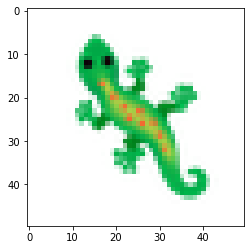

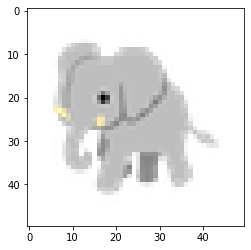

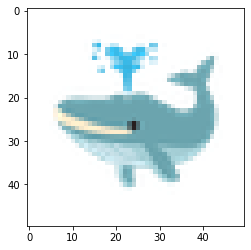

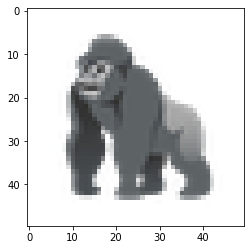

torch.Size([4, 50, 50, 4])
torch.Size([2, 4, 50, 50])
tensor([[ 0.0085, -0.0089,  0.0085, -0.0095, -0.0082,  0.0077],
        [ 0.0026,  0.0029, -0.0067, -0.0019,  0.0090,  0.0185],
        [ 0.0041,  0.0073, -0.0117,  0.0021,  0.0091,  0.0159],
        [ 0.0257,  0.0088, -0.0022, -0.0107,  0.0066,  0.0067]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([ 0.0085, -0.0089,  0.0085, -0.0095, -0.0082,  0.0077], device='cuda:0',
       grad_fn=<SelectBackward>)


In [6]:

#set up the batch and visualization
def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  #imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

       
def to_rgba(x):
  return x[..., :4]

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], x[...,3:4]
  return 1.0-a+rgb

def padimg(x):
    p = TARGET_PADDING
    x = torch.tensor(x)
    return F.pad(x, [0,0,p,p,p,p])
    
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)


lizzy = padimg(load_emoji("🦎"))

print(lizzy.shape)
plt.imshow(to_rgb(lizzy))
plt.show()

elly = padimg(load_emoji("🐘"))

plt.imshow(to_rgb(elly))
plt.show()

whale = padimg(load_emoji("🐳"))

plt.imshow(to_rgb(whale))
plt.show()

monke = padimg(load_emoji("🦍"))

plt.imshow(to_rgb(monke))
plt.show()


batch = torch.stack([monke,lizzy,elly,whale]).to(device)
print(batch.shape)
print(torch.stack([monke,lizzy]).transpose(1,3).shape)
print(ca.encode(batch))
print(ca.encode(batch)[0])

# Functions to display everything in a notebook made by google

In [7]:

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)
def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()
def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

batch (before/after):


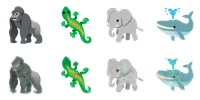

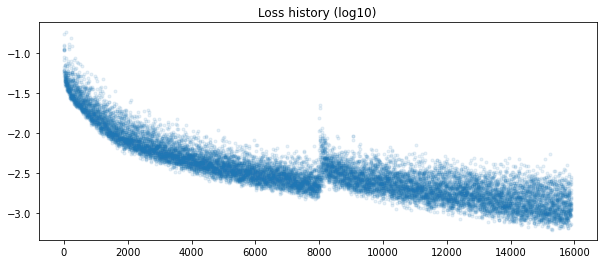

15900 0.0023292514961212873


In [8]:
loss_log = []

class MyPool:
    """This is called MyPool because I made it.
    there is also a pool made by google but the code made 
    no sense to me so I use this.
    All this class does is save previous CA outputs to use
    as inputs later in order to encourage longevity."""
    def __init__(self,maxsize=40):
        self.xs=[]
        self.labels=[]
        self.maxsize=maxsize
    def sample(self, n):
        idx = np.random.choice(len(self.xs), n, False)
        xs = torch.stack([self.xs[i] for i in idx])
        labels = torch.stack([self.labels[i] for i in idx])
        return xs,labels

    def commit(self,x,label):
        x = x.detach().clone()
        label = label.detach().clone()
        i = (len(self.xs)==self.maxsize)*1
        self.xs=self.xs[i:]+[x]
        self.labels=self.labels[i:]+[label]
    @property
    def length(self):
        return len(self.xs)
    def clear(self):
        self.xs=[]
        self.labels=[]

def train(x, target, steps, optimizer, scheduler,encode):
    x = ca(x, steps=steps,encode=encode)
    loss = F.mse_loss(x[:, :, :, :4], target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss

def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])


pool = MyPool()

for i in range(16000):#(16000+1):
    
  if pool.length < BATCH_SIZE or np.random.random()<0.5 or i<8000:
      label= x0 = batch
      x, loss = train(x0, label, np.random.randint(64,96), optimizer, scheduler,True)
  else:
    x0,label=pool.sample(BATCH_SIZE)
    x,loss = train(x0, label, np.random.randint(64,96), optimizer, scheduler,False)
    
  #TODO: add back damage  
  for j in range(BATCH_SIZE):
    #if np.random.random()<=(2.0/BATCH_SIZE):
    pool.commit(x[j],label[j])

  step_i = len(loss_log)
  loss_log.append(loss.item())
    
  #if step_i%10 == 0:
    #generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    #this is to stop the encoder and ca from getting too out of sync  
    pool.clear()
    clear_output()
    visualize_batch(x0.detach().cpu(), x.detach().cpu(), step_i)
    plot_loss(loss_log)
    #export_model(ca, 'train_log/%04d'%step_i)
    print(i,loss.item())#print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

# Quick Demo

In [42]:
dna=ca.encode(batch)
print(dna)

tensor([[ 0.0355,  0.0066, -0.2279,  0.0509,  0.0011, -0.1935],
        [-0.1723, -0.8513, -0.0149,  0.2985,  1.0335,  0.5887],
        [-0.2436, -0.0228,  0.1107, -0.1083, -0.0199,  0.0631],
        [ 0.2939, -0.5961,  0.0724, -0.2899,  0.0191,  0.1385]],
       device='cuda:0', grad_fn=<AddmmBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


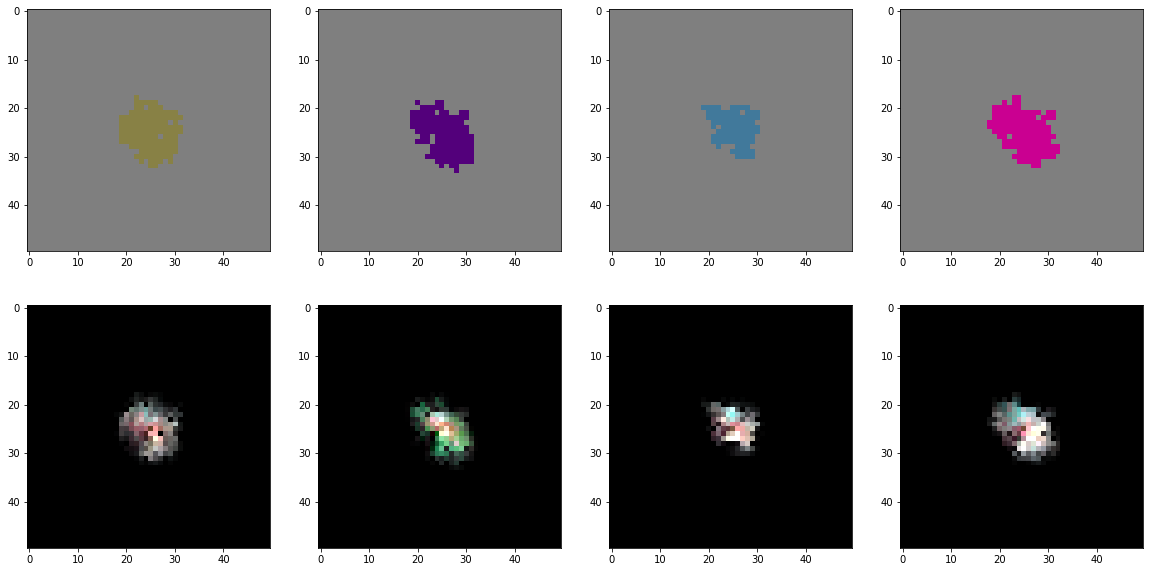

In [43]:
plt.rcParams['figure.figsize'] = [20,10]
out=ca(batch, steps=10,encode=True).detach().clone()

monke,lizard,elephant,whale=out[0],out[1],out[2],out[3]
fig,axs=plt.subplots(2,4)
axs[0][0].imshow(monke[:,:,-6:-3].cpu()+0.5)
axs[1][0].imshow(monke[:,:,:3].cpu())
axs[0][1].imshow(lizard[:,:,-6:-3].cpu()+0.5)
axs[1][1].imshow(lizard[:,:,:3].cpu())
axs[0][2].imshow(elephant[:,:,-6:-3].cpu()+0.5)
axs[1][2].imshow(elephant[:,:,:3].cpu())
axs[0][3].imshow(whale[:,:,-6:-3].cpu()+0.5)
axs[1][3].imshow(whale[:,:,:3].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


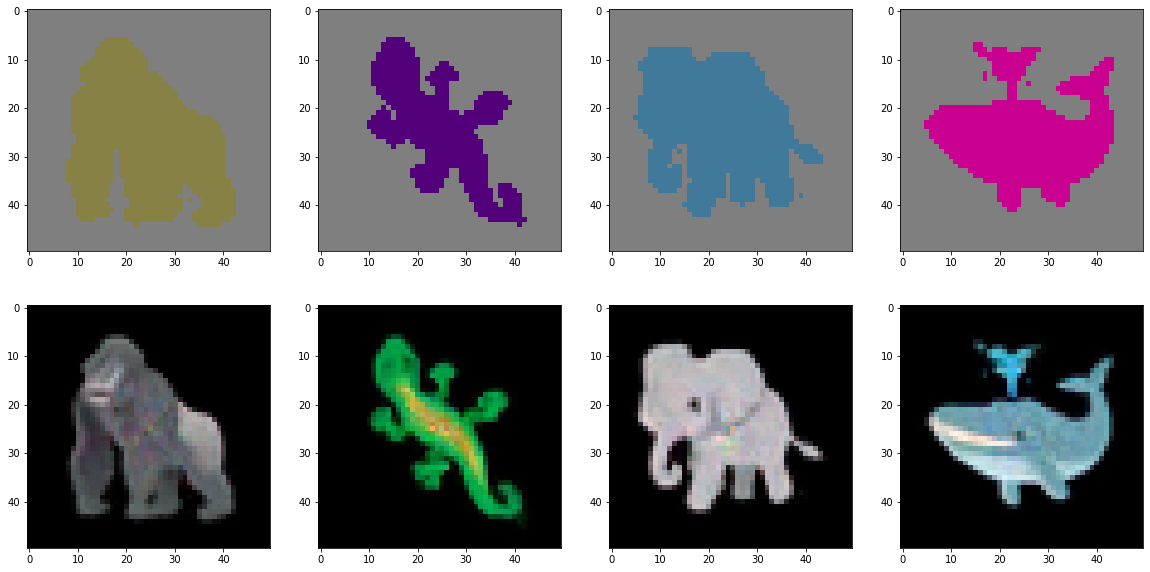

In [44]:
out=ca(out, steps=70,encode=False).detach().clone()

monke,lizard,elephant,whale=out[0],out[1],out[2],out[3]
fig,axs=plt.subplots(2,4)
axs[0][0].imshow(monke[:,:,-6:-3].cpu()+0.5)
axs[1][0].imshow(monke[:,:,:3].cpu())
axs[0][1].imshow(lizard[:,:,-6:-3].cpu()+0.5)
axs[1][1].imshow(lizard[:,:,:3].cpu())
axs[0][2].imshow(elephant[:,:,-6:-3].cpu()+0.5)
axs[1][2].imshow(elephant[:,:,:3].cpu())
axs[0][3].imshow(whale[:,:,-6:-3].cpu()+0.5)
axs[1][3].imshow(whale[:,:,:3].cpu())

# Note: There aren't enough samples here to get any other images to grow

torch.Size([50, 50, 4])
torch.Size([50, 50, 4])


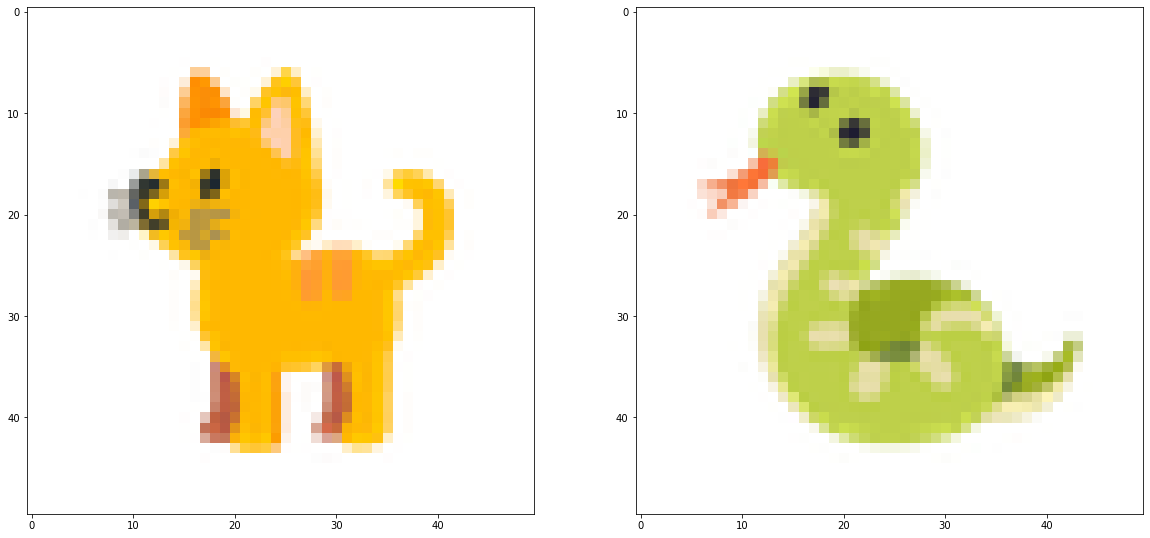

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


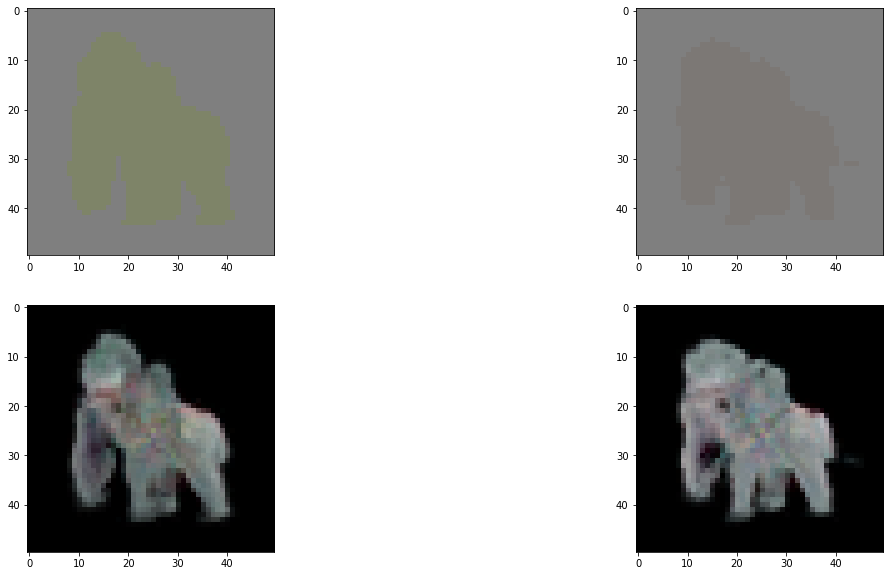

In [45]:
cat = padimg(load_emoji("🐈"))
fig,axs=plt.subplots(1,2)
print(cat.shape)
axs[0].imshow(to_rgb(cat))

snake=padimg(load_emoji("🐍"))
print(snake.shape)
axs[1].imshow(to_rgb(snake))
plt.show()

seed = np.zeros([2,CHANNEL_N],dtype=np.float32)
seed[:,3:]=1.0
init_=torch.tensor(seed).to(device)

test = torch.stack([cat,snake]).to(device)

seedimg = ca.toimage(ca.encode(test),init_)
out=ca(seedimg, steps=70,encode=False).detach().clone()

cat=out[0]
snake=out[1]
fig,axs=plt.subplots(2,2)
axs[0][0].imshow(cat[:,:,-6:-3].cpu()+0.5)
axs[1][0].imshow(cat[:,:,:3].cpu())
axs[0][1].imshow(snake[:,:,-6:-3].cpu()+0.5)
axs[1][1].imshow(snake[:,:,:3].cpu())